In [1]:
!pip install pandas

pyspark 2.3.2 requires py4j==0.10.7, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os 
import pandas as pd

import matplotlib.pyplot as plt

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local").appName("test").config("spark.driver.maxResultSize", "6g").getOrCreate()
spark.conf.set('spark.network.timeout','100000000s')
spark.conf.set('spark.executor.memory', '6g')
spark.conf.set('spark.driver.memory','6g')
spark.conf.set('spark.executor.heartbeatInterval','10000000s')
spark.conf.set('spark.driver.cores','2')

In [11]:
from pyspark.sql.types import *
schema = StructType([
    StructField("id", StringType(), True),
    StructField("txid", StringType(), True),
    StructField("blocktime", StringType(), True),
    StructField("in_number", DoubleType(), True),
    StructField("out_number", DoubleType(), True),
    StructField("fee", FloatType(), True),
    StructField("fee_per_byte", FloatType(), True),
    StructField("blockhash", StringType(), True),
    StructField("preblockhash", StringType(), True)])

fee_df = spark.read.load("gs://bucket-1-btc/block-ALL-Fee/*-txFee.csv", format="csv", delimiter="\t", header=True, schema=schema)
fee_df.take(2)

[Row(id='0', txid='0ec8b11affb6b9b89862a839cb1045f6b292882b6fe39a1c59dd18bb970c47e6', blocktime='1527829752', in_number=1.0, out_number=2.0, fee=0.0, fee_per_byte=0.0, blockhash='0000000000000000002f83786a45e29037f5198994042f814b036be402214090', preblockhash='0000000000000000000c9a2d821bcb65b2d221442f20c9fde4642f6a478ae334'),
 Row(id='1', txid='1643f0e9d43226030fe3c2f8a4811ecf911b4a90fe7c6bed4ddcc0e1b66308ea', blocktime='1527829752', in_number=15.0, out_number=5.0, fee=-3.000000106112566e-06, fee_per_byte=-1.0416666418322507e-09, blockhash='0000000000000000002f83786a45e29037f5198994042f814b036be402214090', preblockhash='0000000000000000000c9a2d821bcb65b2d221442f20c9fde4642f6a478ae334')]

In [28]:
# from datetime import datetime
# txid_fees = fee_df.rdd.map(lambda tx: {"txid": tx.txid, "fee": (tx.fee * 1), "blocktime": datetime.utcfromtimestamp(int(tx.blocktime)).strftime('%Y%m%d')})
# txid_fees.take(5)

fee_df.createOrReplaceTempView("table1")
txid_fees = spark.sql("SELECT table2.blocktime, feemean \
                      from (SELECT from_unixtime(blocktime,'yyyy-MM-dd') as blocktime, mean(fee) as feemean \
                      from table1 \
                      group by from_unixtime(blocktime,'yyyy-MM-dd') ) as table2\
                      order by table2.blocktime")


txid_fees.take(5)

[Row(blocktime='2018-05-31', feemean=8.932210230016562e-05),
 Row(blocktime='2018-06-01', feemean=9.915659131885363e-05),
 Row(blocktime='2018-06-02', feemean=9.328776826337217e-05),
 Row(blocktime='2018-06-03', feemean=9.365653168432295e-05),
 Row(blocktime='2018-06-04', feemean=9.865636390265252e-05)]

In [ ]:
from datetime import datetime
txid_fees2 = fee_df.rdd.groupBy(datetime.utcfromtimestamp(int("blocktime")).strftime('%Y%m%d')).agg(datetime.utcfromtimestamp(int("blocktime")).strftime('%Y%m%d'),mean("fee"))
txid_fees2.take(5)


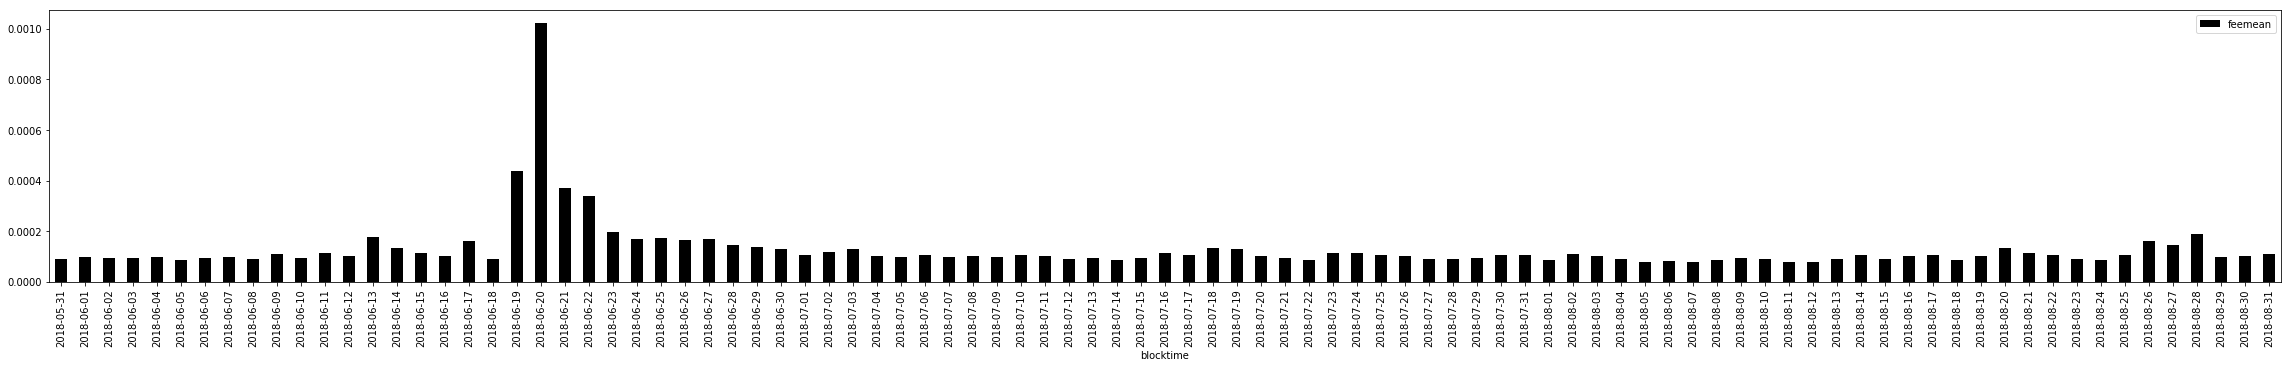

In [29]:
import matplotlib as plt
%matplotlib inline

#pd_fees = pd.DataFrame(txid_fees)
# tx_fee_mean = pd_fees.groupby(['blocktime'], as_index=False).mean()
# tx_fee_mean.plot(x='blocktime', y='fee', kind= 'bar', color='black', figsize=(40, 5))

pd_fees = txid_fees.toPandas() 
pd_fees.plot(x='blocktime', y='feemean', kind= 'bar', color='black', figsize=(40, 5))

In [30]:
# txids = fee_df.rdd.map(lambda r: {'blocktime': datetime.utcfromtimestamp(int(r.blocktime)).strftime('%Y%m%d')}).collect()
# txids[0:5]

fee_df.createOrReplaceTempView("table1")
txids = spark.sql("SELECT table2.blocktime, counttxid \
                      from (SELECT from_unixtime(blocktime,'yyyy-MM-dd') as blocktime, count(txid) as counttxid \
                      from table1 \
                      group by from_unixtime(blocktime,'yyyy-MM-dd') ) as table2\
                      order by table2.blocktime")


txids.take(5)

[Row(blocktime='2018-05-31', counttxid=76600),
 Row(blocktime='2018-06-01', counttxid=205481),
 Row(blocktime='2018-06-02', counttxid=174497),
 Row(blocktime='2018-06-03', counttxid=163443),
 Row(blocktime='2018-06-04', counttxid=209939)]

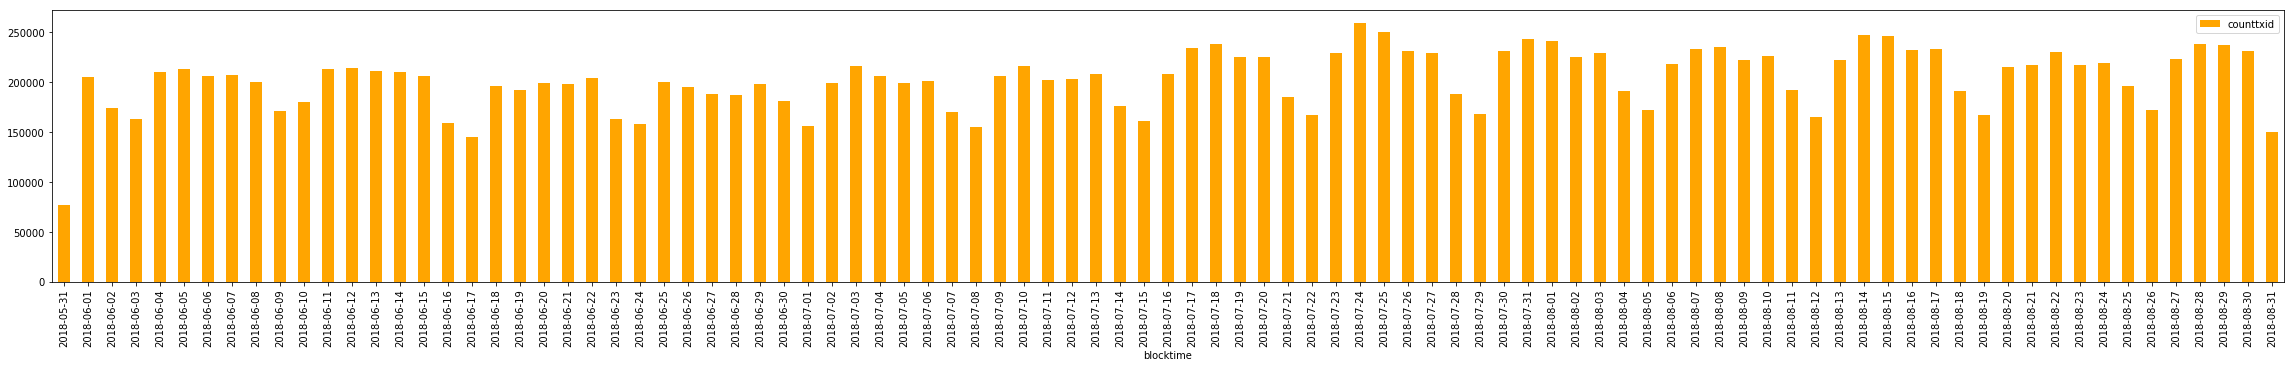

In [32]:
import numpy as np

# pd_txs = pd.DataFrame(txids)
# tx_size = pd_txs.groupby(['blocktime'], as_index=False).size().reset_index(name='count')
# tx_size.plot(x='blocktime', y='count', kind='bar', color='orange', figsize=(40, 5))
pd_txs = txids.toPandas() 
pd_txs.plot(x='blocktime', y='counttxid', kind='bar', color='orange', figsize=(40, 5))

[Row(blocktime='2018-05-31', fee_per_byte_mean=1.6794581011937128e-07), Row(blocktime='2018-06-01', fee_per_byte_mean=1.7494546385474232e-07), Row(blocktime='2018-06-02', fee_per_byte_mean=1.6680191101882804e-07), Row(blocktime='2018-06-03', fee_per_byte_mean=1.6767647173526635e-07), Row(blocktime='2018-06-04', fee_per_byte_mean=1.722040036163268e-07)]


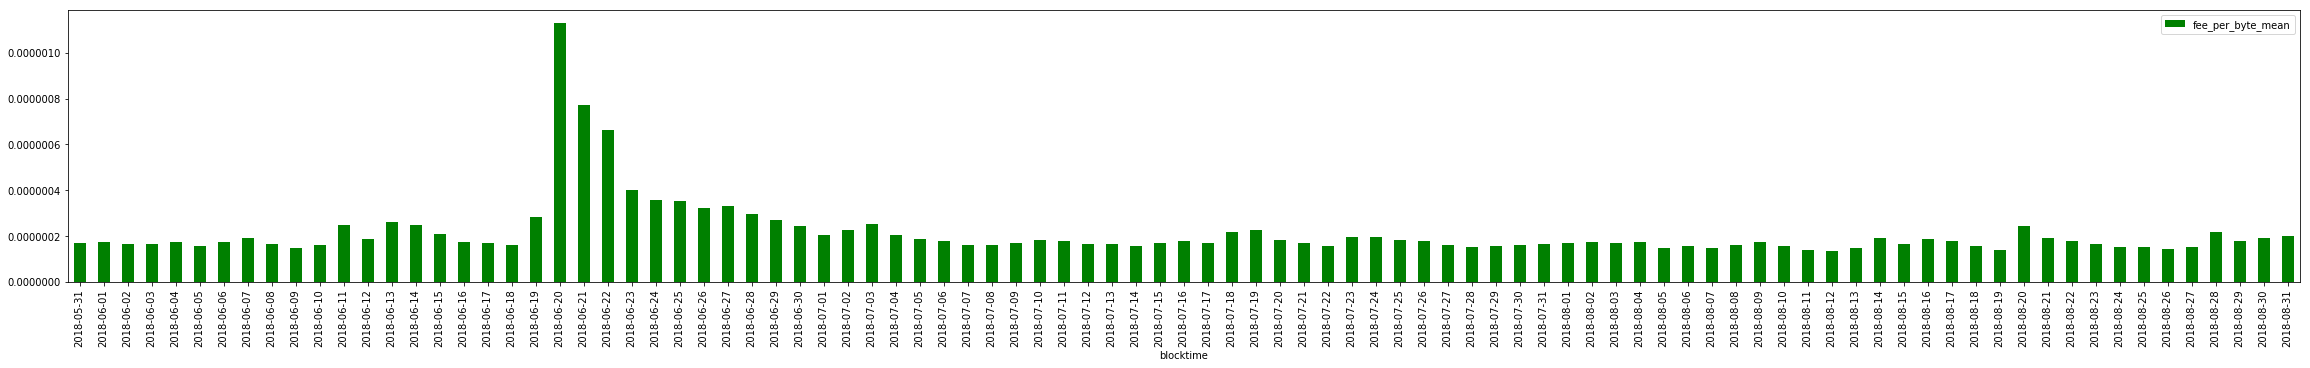

In [35]:
# tx_fee_per_byte = fee_df.rdd.map(lambda tx: {"txid": tx.txid, "fee_per_byte": tx.fee_per_byte, "blocktime": datetime.utcfromtimestamp(int(tx.blocktime)).strftime('%Y%m%d%H%M')}).collect()
# pd_fee_per_byte = pd.DataFrame(tx_fee_per_byte)
# tx_fee_per_byte_mean = pd_fee_per_byte.groupby(['blocktime'], as_index=False).mean()
# tx_fee_per_byte_mean.plot(x='blocktime', y='fee_per_byte', kind='bar', color='green', figsize=(40, 5))

fee_df.createOrReplaceTempView("table1")
tx_fee_per_byte = spark.sql("SELECT table2.blocktime, fee_per_byte_mean \
                      from (SELECT from_unixtime(blocktime,'yyyy-MM-dd') as blocktime, mean(fee_per_byte) as fee_per_byte_mean \
                      from table1 \
                      group by from_unixtime(blocktime,'yyyy-MM-dd') ) as table2\
                      order by table2.blocktime")


print(tx_fee_per_byte.take(5))
tx_fee_per_byte_mean = tx_fee_per_byte.toPandas() 
tx_fee_per_byte_mean.plot(x='blocktime', y='fee_per_byte_mean', kind='bar', color='green', figsize=(40, 5))

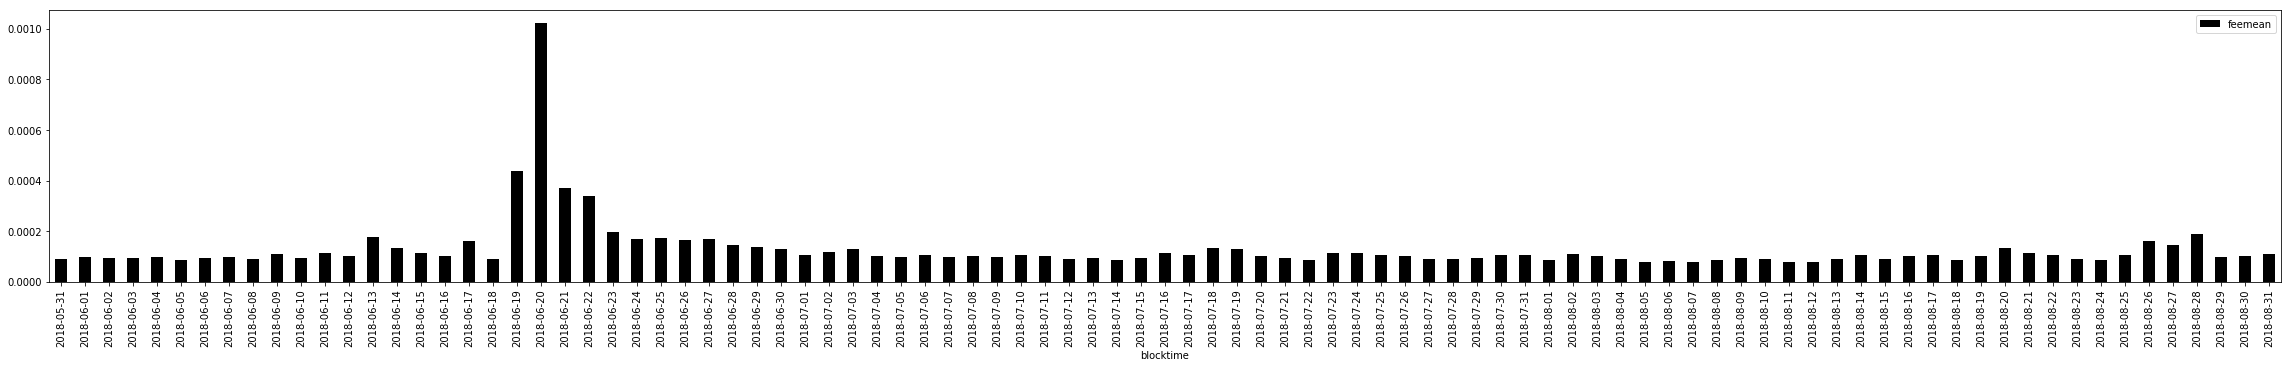

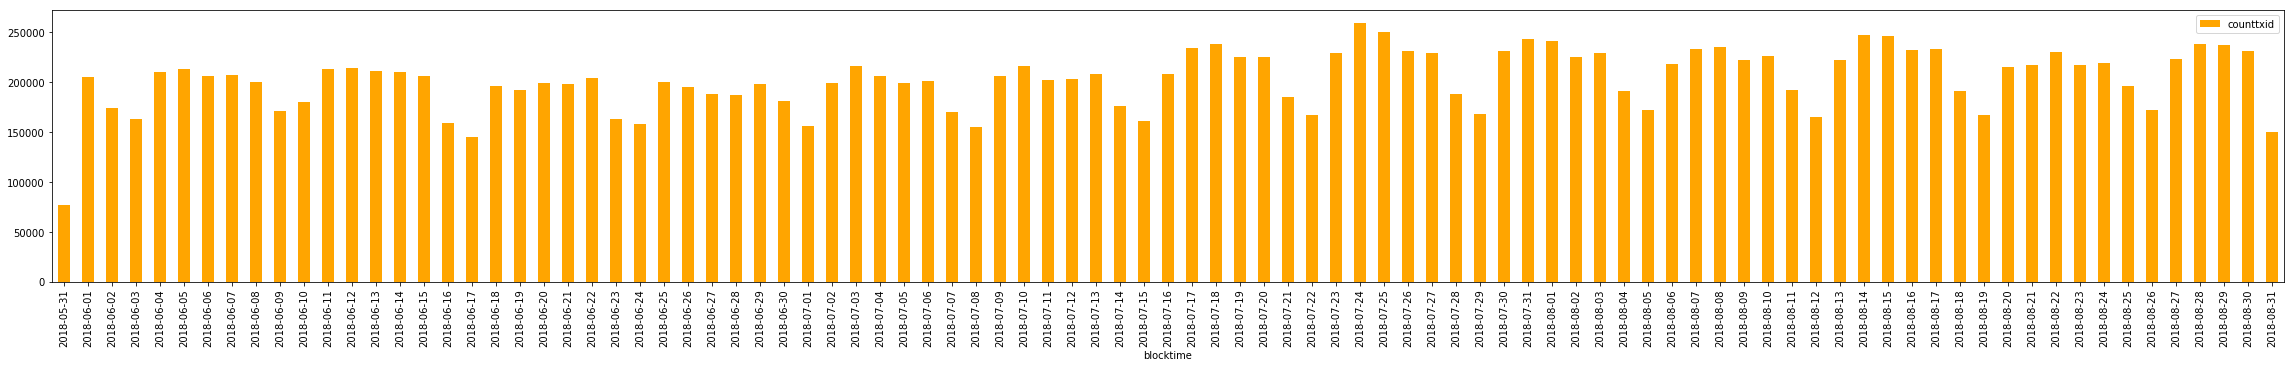

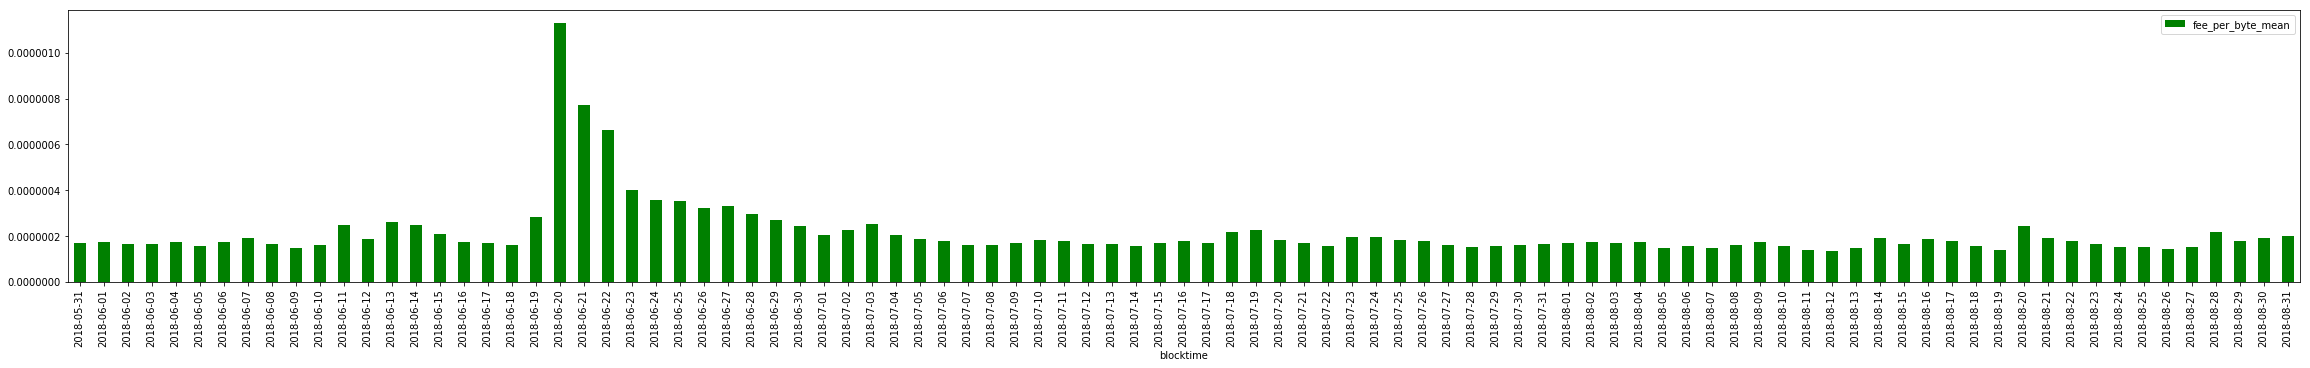

In [36]:
# pd_tx_size = pd.DataFrame(tx_size)
# pd_tx_fee_mean = pd.DataFrame(tx_fee_mean)
# pd_fee_per_byte = pd.DataFrame(tx_fee_per_byte_mean)
# pd_all = pd_tx_size.join(pd_tx_fee_mean.set_index('blocktime'), on='blocktime').join(pd_fee_per_byte.set_index('blocktime'), on='blocktime')

# pd_all.plot(x='blocktime', y='fee', color='black', kind='bar', figsize=(40, 5))
# pd_all.plot(x='blocktime', y='count', color='orange', kind='bar', figsize=(40, 5))
# pd_all.plot(x='blocktime', y='fee_per_byte', color='green', kind='bar', figsize=(40, 5))

pd_tx_size = pd.DataFrame(pd_txs)
pd_tx_fee_mean = pd.DataFrame(pd_fees)
pd_fee_per_byte = pd.DataFrame(tx_fee_per_byte_mean)
pd_all = pd_tx_size.join(pd_tx_fee_mean.set_index('blocktime'), on='blocktime').join(pd_fee_per_byte.set_index('blocktime'), on='blocktime')

pd_all.plot(x='blocktime', y='feemean', color='black', kind='bar', figsize=(40, 5))
pd_all.plot(x='blocktime', y='counttxid', color='orange', kind='bar', figsize=(40, 5))
pd_all.plot(x='blocktime', y='fee_per_byte_mean', color='green', kind='bar', figsize=(40, 5))
